In [1]:
# from comet_ml import Experiment
# experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

In [2]:
import numpy as np
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.regularizers import l2
from keras.utils import np_utils 

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os
import fnmatch

import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import itertools

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data

In [4]:
train_path = "I:\\Honours-Project\\data\\sorted\\agg\\train\\"
train_csv = "I:\\Honours-Project\\data\\sorted\\agg\\train\\ids.csv"
test_path = "I:\\Honours-Project\\data\\sorted\\agg\\test\\"
test_csv = "I:\\Honours-Project\\data\\sorted\\agg\\test\\ids.csv"

dest_path = "I:\\Honours-Project\\data\\sorted\\agg\\"

csv = "I:\\Honours-Project\\data\\sorted\\agg\\ids.csv"

In [5]:
df = pd.read_csv(csv,index_col=0).sample(frac=1)

### Downsample to balanced classes

In [6]:
ds_count = min(df.groupby('flow_rate').size())
ds_flow = df.groupby('flow_rate').size().idxmin()

samples = df[df['flow_rate']==1800].sample(n=ds_count)
samples.append(df[df['flow_rate']==3600].sample(n=ds_count))
samples.append(df[df['flow_rate']==7200].sample(n=ds_count))

samples = pd.concat([df[df['flow_rate']==i].sample(n=ds_count) for i in (1800,3600,7200)],ignore_index=True)

df = samples.sample(frac=1)

print(samples.groupby('flow_rate').size())

flow_rate
1800    116
3600    116
7200    116
dtype: int64


In [25]:
df['log_volume'] = df['volume'].apply(np.log)

x = df.drop(columns=['name','date','flow_rate','source','moments','inertia_tensor'])

# Drop catagorical features
mat = x.drop(columns=['euler_number', 'num_peaks', 'cluster'])

a = mat.as_matrix()
# x = standardize = preprocessing.scale(x)

In [8]:
df.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks,log_volume
327,118_flipped,2017.11.22,7200,34.20 s.tifheightmap.mat,8.531226,3004,16022.993157,0.749848,1,0.661237,5.333886,[[3.00400000e+03 1.05119000e+05 4.62409500e+06...,-1.031204,219.379726,[[216.68422529 -91.61993795]\r\n [-91.61993795...,0,1,9.681780
296,73,2017.11.17,7200,5.65 s.tifheightmap.mat,8.775024,12462,54832.268548,0.984844,1,0.606778,4.399957,[[1.24620000e+04 2.17597800e+06 4.54427324e+08...,-1.565982,721.019336,[[ 179.9360201 -27.90561956]\r\n [ -27.90561...,0,1,10.912034
62,4_flipped,2017.11.09,1800,chip2_06heightmap.mat,4.629928,1929,3566.980825,0.871295,1,0.562063,1.849135,[[1.92900000e+03 6.37560000e+04 2.84693000e+06...,1.543902,209.095454,[[ 92.6177739 7.82965009]\r\n [ 7.82965009...,1,1,8.179475
164,11_flipped,2017.11.09,3600,chip3_01heightmap.mat,14.033560,175,708.182643,0.665178,1,0.780000,3.026422,[[2.34000000e+02 2.24600000e+03 2.73880000e+04...,1.523363,54.870058,[[13.9300168 0.52264592]\r\n [ 0.52264592 24...,2,1,6.562702
347,66,2017.11.17,7200,25.15 s.tifheightmap.mat,4.064578,2445,4779.567013,0.909261,1,0.575463,1.922593,[[2.48600000e+03 1.23125000e+05 7.47807700e+06...,-1.305940,284.521861,[[ 135.28370362 -122.912562 ]\r\n [-122.91256...,1,1,8.472105


In [9]:
test_size = int(df.shape[0]/10)

x_test = np.array(x[:test_size])
y_test = df['flow_rate'][:test_size].values

x_train = np.array(x[test_size:])
y_train = df['flow_rate'][test_size:].values

std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std        

## Run Logistic Regression

In [10]:
batch_size = 16
nb_classes = 3
nb_epoch = 30

lmda = 0.05

In [11]:
input_dim = x_train.shape[1]

In [12]:
y_train[y_train == 1800] = 0
y_train[y_train == 3600] = 1
y_train[y_train == 7200] = 2

y_test[y_test == 1800] = 0
y_test[y_test == 3600] = 1
y_test[y_test == 7200] = 2

y_train = np_utils.to_categorical(y_train, nb_classes) 
y_test = np_utils.to_categorical(y_test, nb_classes)

In [13]:
def build_logistic_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(output_dim, input_dim=input_dim,
                    kernel_regularizer=l2(lmda),
                    activation='softmax'))

    return model

In [14]:
model = None
model = build_logistic_model(input_dim, nb_classes)

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [16]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Train on 314 samples, validate on 34 samples
Epoch 1/30
314/314 [==============================] - 3s 9ms/step - loss: 1.6213 - acc: 0.3217 - val_loss: 1.6689 - val_acc: 0.2353
Epoch 2/30
314/314 [==============================] - 0s 344us/step - loss: 1.5470 - acc: 0.3408 - val_loss: 1.5933 - val_acc: 0.2647
Epoch 3/30
314/314 [==============================] - 0s 353us/step - loss: 1.4878 - acc: 0.3408 - val_loss: 1.5312 - val_acc: 0.2647
Epoch 4/30
314/314 [==============================] - 0s 337us/step - loss: 1.4400 - acc: 0.3503 - val_loss: 1.4800 - val_acc: 0.2647
Epoch 5/30
314/314 [==============================] - 0s 328us/step - loss: 1.4012 - acc: 0.3408 - val_loss: 1.4375 - val_acc: 0.2941
Epoch 6/30
314/314 [==============================] - 0s 334us/step - loss: 1.3676 - acc: 0.3376 - val_loss: 1.4020 - val_acc: 0.2941
Epoch 7/30
314/314 [==============================] - 0s 347us/step - loss: 1.3401 - acc: 0.3535 - val_loss: 1.3703 - val_acc: 0.3529
Epoch 8/30
314/314 

In [17]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.107841505723841
Test accuracy: 0.4411764705882353


## Confusion Matrix

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

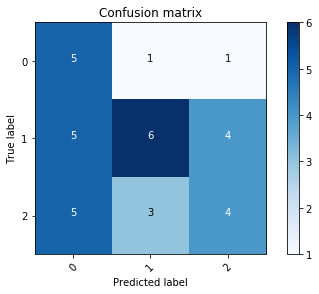

In [19]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

## With Cross Validation

In [20]:
batch_size = 16
nb_classes = 3
nb_epoch = 20

In [21]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    return score[1]

In [22]:
n_folds = 10

labels = df['flow_rate'].values
data = x

labels[labels == 1800] = 0
labels[labels == 3600] = 1
labels[labels == 7200] = 2

labels = np_utils.to_categorical(labels, nb_classes) 

skf = StratifiedKFold(df['flow_rate'].values, n_folds=n_folds, shuffle=True)
avg_acc = 0

y_true = []
y_pred = []

for i, (train, test) in enumerate(skf):
    print("Running Fold", i+1, "/", n_folds)
    model = None # Clearing the NN.
    model = build_logistic_model(input_dim, nb_classes)
    
    std = np.std(data[train],0)
    mean = np.mean(data[train],0)
    
    x_train = (data[train]-mean)/std
    x_test = (data[test] - mean)/std        
    
    avg_acc += train_and_evaluate_model(model, x_train, labels[train], x_test, labels[test])
    
    # Predict the values from the validation dataset
    Y_pred = model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(labels[test],axis = 1) 
    
    y_true.extend(Y_true)
    y_pred.extend(Y_pred_classes)

Running Fold 1 / 10
Train on 312 samples, validate on 36 samples
Epoch 1/20
312/312 [==============================] - 0s 1ms/step - loss: 1.4575 - acc: 0.3494 - val_loss: 1.4218 - val_acc: 0.5278
Epoch 2/20
312/312 [==============================] - 0s 346us/step - loss: 1.3899 - acc: 0.3558 - val_loss: 1.3386 - val_acc: 0.5833
Epoch 3/20
312/312 [==============================] - 0s 436us/step - loss: 1.3398 - acc: 0.3526 - val_loss: 1.2824 - val_acc: 0.5833
Epoch 4/20
312/312 [==============================] - 0s 324us/step - loss: 1.3024 - acc: 0.3654 - val_loss: 1.2418 - val_acc: 0.5556
Epoch 5/20
312/312 [==============================] - 0s 336us/step - loss: 1.2736 - acc: 0.3750 - val_loss: 1.2142 - val_acc: 0.5000
Epoch 6/20
312/312 [==============================] - 0s 375us/step - loss: 1.2504 - acc: 0.3622 - val_loss: 1.1929 - val_acc: 0.4444
Epoch 7/20
312/312 [==============================] - 0s 327us/step - loss: 1.2322 - acc: 0.3718 - val_loss: 1.1770 - val_acc: 0.4444

312/312 [==============================] - 0s 324us/step - loss: 1.1299 - acc: 0.4295 - val_loss: 1.1683 - val_acc: 0.3333
Epoch 20/20
312/312 [==============================] - 0s 317us/step - loss: 1.1240 - acc: 0.4263 - val_loss: 1.1651 - val_acc: 0.3333
Running Fold 4 / 10
Train on 312 samples, validate on 36 samples
Epoch 1/20
312/312 [==============================] - 0s 1ms/step - loss: 1.7147 - acc: 0.2821 - val_loss: 1.3861 - val_acc: 0.3611
Epoch 2/20
312/312 [==============================] - 0s 317us/step - loss: 1.5840 - acc: 0.2821 - val_loss: 1.3181 - val_acc: 0.3611
Epoch 3/20
312/312 [==============================] - 0s 311us/step - loss: 1.4805 - acc: 0.2788 - val_loss: 1.2659 - val_acc: 0.3611
Epoch 4/20
312/312 [==============================] - 0s 317us/step - loss: 1.3935 - acc: 0.2821 - val_loss: 1.2271 - val_acc: 0.3333
Epoch 5/20
312/312 [==============================] - 0s 327us/step - loss: 1.3272 - acc: 0.2853 - val_loss: 1.1998 - val_acc: 0.3333
Epoch 6/2

312/312 [==============================] - 0s 327us/step - loss: 1.1665 - acc: 0.4006 - val_loss: 1.2082 - val_acc: 0.3611
Epoch 18/20
312/312 [==============================] - 0s 327us/step - loss: 1.1584 - acc: 0.3974 - val_loss: 1.1980 - val_acc: 0.3611
Epoch 19/20
312/312 [==============================] - ETA: 0s - loss: 1.1436 - acc: 0.408 - 0s 304us/step - loss: 1.1506 - acc: 0.4006 - val_loss: 1.1886 - val_acc: 0.3611
Epoch 20/20
312/312 [==============================] - 0s 314us/step - loss: 1.1440 - acc: 0.3910 - val_loss: 1.1784 - val_acc: 0.3333
Running Fold 7 / 10
Train on 315 samples, validate on 33 samples
Epoch 1/20
315/315 [==============================] - 0s 2ms/step - loss: 1.6859 - acc: 0.3492 - val_loss: 1.7179 - val_acc: 0.4545
Epoch 2/20
315/315 [==============================] - 0s 416us/step - loss: 1.5943 - acc: 0.3492 - val_loss: 1.6133 - val_acc: 0.4545
Epoch 3/20
315/315 [==============================] - 0s 324us/step - loss: 1.5141 - acc: 0.3460 - val_

315/315 [==============================] - 0s 355us/step - loss: 1.1480 - acc: 0.3873 - val_loss: 1.1990 - val_acc: 0.3939
Epoch 17/20
315/315 [==============================] - 0s 333us/step - loss: 1.1429 - acc: 0.3937 - val_loss: 1.1942 - val_acc: 0.3939
Epoch 18/20
315/315 [==============================] - 0s 327us/step - loss: 1.1382 - acc: 0.3937 - val_loss: 1.1897 - val_acc: 0.3939
Epoch 19/20
315/315 [==============================] - 0s 336us/step - loss: 1.1335 - acc: 0.3968 - val_loss: 1.1858 - val_acc: 0.3939
Epoch 20/20
315/315 [==============================] - 0s 301us/step - loss: 1.1294 - acc: 0.3937 - val_loss: 1.1815 - val_acc: 0.3939
Running Fold 10 / 10
Train on 315 samples, validate on 33 samples
Epoch 1/20
315/315 [==============================] - 1s 2ms/step - loss: 1.6318 - acc: 0.3397 - val_loss: 1.1990 - val_acc: 0.4545
Epoch 2/20
315/315 [==============================] - 0s 330us/step - loss: 1.5408 - acc: 0.3460 - val_loss: 1.1794 - val_acc: 0.4545
Epoch

In [23]:
print("Average Accuracy: ", avg_acc/n_folds)

Average Accuracy:  0.3820707070707071


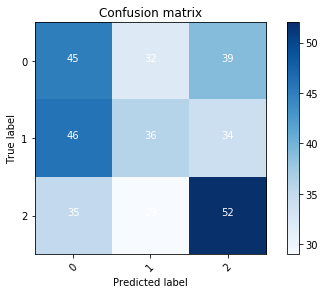

In [24]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(y_true), np.array(y_pred)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 